In [40]:
import numpy as np
import matplotlib.pyplot as plt
import lib.calc as c
from skimage import morphology, restoration, filters, exposure
%matplotlib qt5

Read the data and store it in the `small_1` dictionary. Access the intensity by calling `small_1[<scan_no>]['<roi>'][2]`.

In [41]:
sf = '/data/id01/inhouse/IHR/HC3313/spec/e17089_fast_00022.spec'
rois_103 = ['roi1', 'roi3', 'roi2', 'roi4', 'roi5']
scan_list = [10,15,21,27,33,39,45,51,57,63,69,75,80,85,90]

# for i,scan in enumerate(scan_list):
#     scan_list[i] = scan + 3
    
print(scan_list)    

small_1 = dict()
for scan in scan_list:
    small_1[scan] = c.read_kmap(sf, scan, rois_103) # out is piy, pix, int per each roi

[10, 15, 21, 27, 33, 39, 45, 51, 57, 63, 69, 75, 80, 85, 90]


In [42]:
from silx.io import specfile as spec

scan_no = 10
rois = ['roi1']
# read the specfile
sf = spec.SpecFile(sf)
# get the data
data = sf[scan_no].data
# get spec indexes
index_list = sf.labels(scan_no)
actual_num = sf.keys()[scan_no]
# init results dict
res = {}

Test data to demonstrate watershed segmentation:

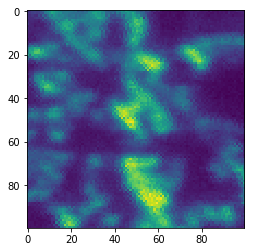

In [43]:
kmap = small_1[10]['roi1'][2]
plt.imshow(kmap);

Perform watershed.

/users/zatterin/Envs/py3/lib/python3.5/site-packages/skimage/restoration/non_local_means.py:108: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


Text(0.5,1,'Watershed')

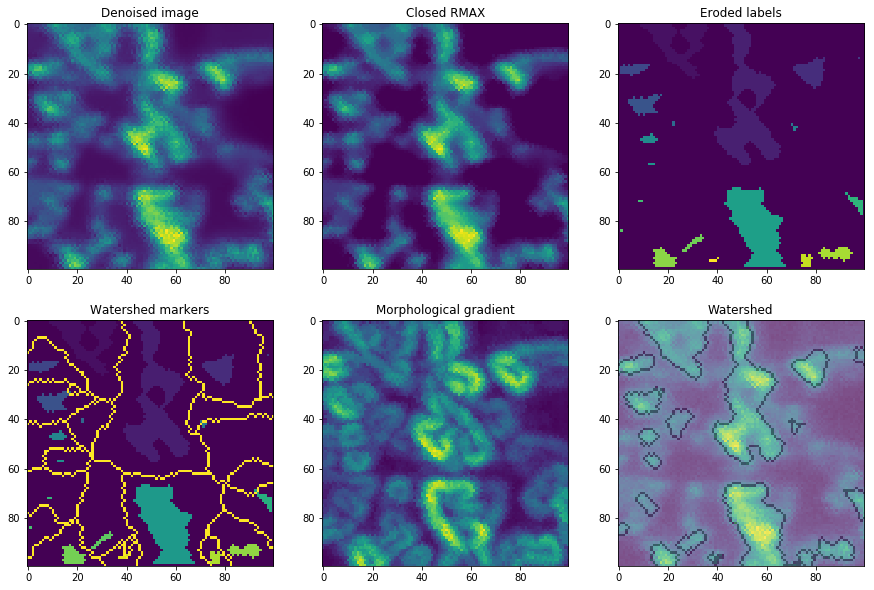

In [44]:
## Determine Regional maxima
# denoise the image
sigma_est = restoration.estimate_sigma(kmap)
kmapd = restoration.denoise_nl_means(kmap, h=0.8*sigma_est)
# make seed and mask for regional max determination
h = 700
seed_rmax = kmapd - h
mask_rmax = kmapd
# HMAX: reconstruction by dilation
hmax = morphology.reconstruction(seed_rmax, mask_rmax, method='dilation', selem=morphology.selem.disk(1))
# RMAX
rmax = kmapd - hmax
# close gaps in rmax
rmax = morphology.closing(rmax, selem=morphology.selem.disk(1)) 
# treshold closed rmax
ots = filters.threshold_otsu(rmax, nbins=int(rmax.max())) 
ts_rmax = rmax > ots # binary rmax
# erode: sure fg pixels
ts_rmax = morphology.binary_erosion(ts_rmax, selem=morphology.selem.disk(1))
# label thresholded rmax
inner_markers, nlabels = morphology.label(ts_rmax, neighbors=4, return_num=True) 

## Watershed
# use labeled rmax markers are basin markers in negated kmap
wshed_bkg = morphology.watershed(-kmapd, inner_markers, watershed_line=True)
# watershed bkg lines are given max integer label
lines = (wshed_bkg==0).astype('int8')
lines[wshed_bkg==0] = nlabels + 1
# total markers for watershed
markers = inner_markers + lines
# morpho gradient
mgrad = morphology.dilation(kmap,selem=morphology.selem.disk(3)) - morphology.erosion(kmap,selem=morphology.selem.disk(3))
# watershed
wshed = morphology.watershed(mgrad, markers, watershed_line=True)

## Plot
fig, axes = plt.subplots(2,3, figsize=(15,10))
ax = axes.ravel()

ax[0].imshow(kmapd) # denoised image
ax[0].set_title('Denoised image')

ax[1].imshow(rmax) # closed regional max
ax[1].set_title('Closed RMAX')

ax[2].imshow(inner_markers) # eroded labels
ax[2].set_title('Eroded labels')

ax[3].imshow(markers) # inner and outer watershed markers
ax[3].set_title('Watershed markers')

ax[4].imshow(mgrad) # morpho gradient of original image
ax[4].set_title('Morphological gradient')

ax[5].imshow(kmap)
ax[5].imshow(wshed==0,cmap='Reds',alpha=0.3) # final watershed
ax[5].set_title('Watershed')

**realisation: in this case global segmentation is better. also: still have to try the distance trasform.**

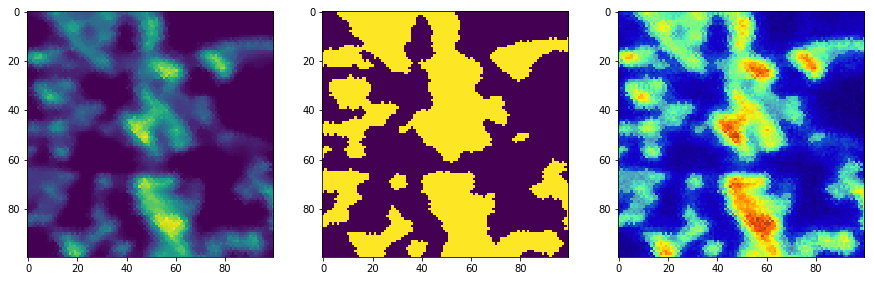

In [45]:
hist, binc = exposure.histogram(rmax, nbins=int(rmax.max()))
# ts = filters.threshold_otsu(rmax, nbins=int(rmax.max()))
# ts = filters.threshold_otsu(kmap, nbins=int(kmap.max()))
ts = filters.threshold_li(rmax)
# ts = filters.threshold_mean(rmax)
ts_rmax = rmax > ts


fig, ax = plt.subplots(1,3,figsize=(15,6))

ax[0].imshow(rmax)
ax[1].imshow(ts_rmax)
ax[2].imshow(kmap,cmap='jet')
ax[2].imshow(ts_rmax,alpha=0.3)

In [46]:
rmax.min()

0.0